In [3]:
from qiskit import QuantumCircuit

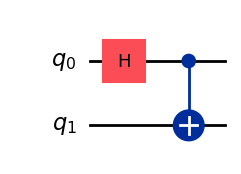

In [4]:
# bell state

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw(output='mpl')

In [5]:
# signature of entanglement

from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, XX, XI, IX]

In [6]:
# run local simulator
from qiskit_aer.primitives import Estimator

estimator = Estimator()
job = estimator.run([qc] * len(observables), observables)

print(job.result())

EstimatorResult(values=array([ 1.        , -0.02539062, -0.02539062,  1.        , -0.02148438,
       -0.02148438]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0056365, 'sample_measure_time': 0.0006561, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 16298, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9993553161621094, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0056365, 'sample_measure_time': 0.0006

Text(0, 0.5, 'values')

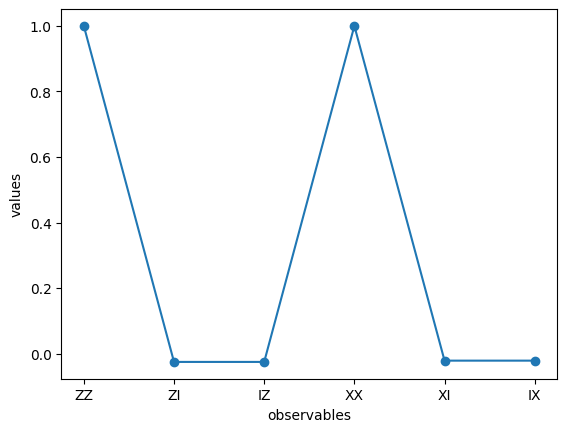

In [7]:
# plot the correlations
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('observables')
plt.ylabel('values')

# Now Let's do a 100-qubit example

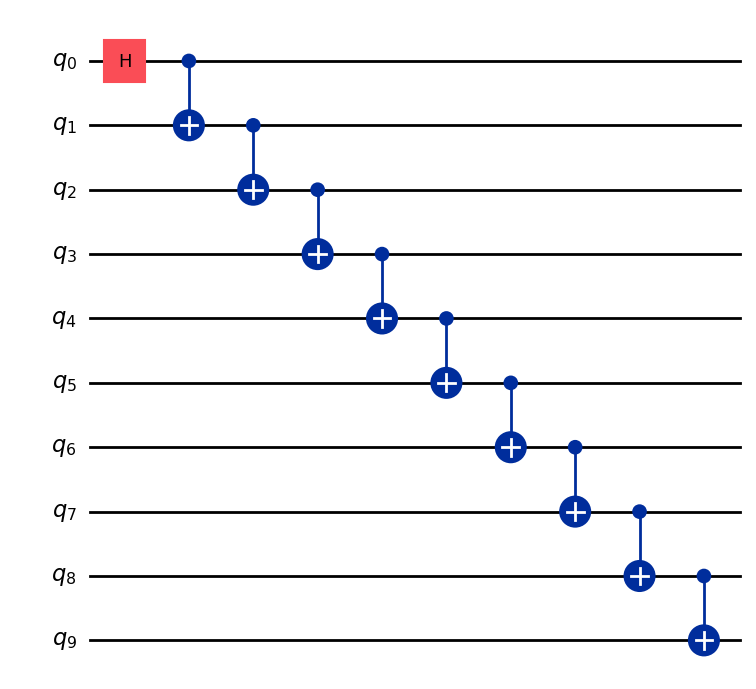

In [8]:
def n_qubit_GHZ(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc

test_qc = n_qubit_GHZ(10)

test_qc.draw(output='mpl')

### How noisy do qubits get as they stray farther and farther from the hadamard'ed qubit?

In [19]:
# Analyze all adjacent pair-wise expectation values
from qiskit.quantum_info import SparsePauliOp

n = 100

qc = n_qubit_GHZ(n)

operator_strings = ['Z' + 'I' * i + 'Z' + 'I' * (n-2-i) for i in range(n-1)]

print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(oper_string) for oper_string in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [20]:
# large number of qubits, so let's optimize for IBM hardware
from dotenv import load_dotenv
import os

load_dotenv()
qiskit_key = os.getenv("QISKIT_API_KEY")


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel="ibm_cloud",
                     token=qiskit_key)
backend = service.backend(name="ibm_torino")
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

qiskit_runtime_service._discover_account:WARNING:2026-02-11 00:17:05,073: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2026-02-11 00:17:09,977: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: Developer Cert. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-11 00:17:09,978: Using instance: Developer Cert, plan: open


In [21]:
# execute on the backend
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)

In [ ]:
# Don't run this cell

#job = estimator.run([(qc_transpiled, operators_transpiled_list)])
#job_id = job.job_id()
#print(job_id)

d663m3je4kfs73d05oeg


Job ID: d663m3je4kfs73d05oeg

In [23]:
# load the job
job_id = 'd663m3je4kfs73d05oeg'
job = service.job(job_id)

In [ ]:
# post-process


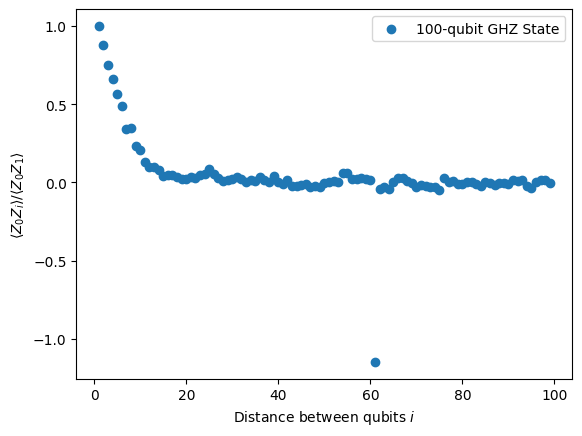

In [25]:
# plot
import matplotlib.pyplot as plt

data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v/values[0] for v in values]

plt.scatter(data, values, marker='o', label='100-qubit GHZ State')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle$')
plt.legend()
plt.show()